## Organizando dados para a Apresentação Final

#### Carregando bibliotecas

In [1]:
import os
import glob
import json
import openpyxl
import pandas as pd
import pandas.io.json as pd_json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="white")

#### Funções auxiliares

In [3]:
def listar_arquivos(extensao='json'):
    search = "output/*.{}".format(extensao)
    files = glob.glob(search)
    files.sort()
    return files

In [4]:
def ler_json(caminho):
    with open(caminho) as fp:  
        dados = json.load(fp)
    return dados

In [5]:
def obter_os_contrato(nome_arquivo):
    nome_sem_extensao = nome_arquivo.split('.')[0]
    partes = nome_sem_extensao.split('_')
    return int(partes[1]), int(partes[3])

In [6]:
def obter_codigo_nome_os():
    arquivo = 'input/contratos-controle.xlsx'
    df = pd.read_excel(arquivo, sheet_name='contratos')
    cod_os_nome = {}
    for os in df['ORGANIZACAO']:
        codigo_nome = os.split(' - ')
        cod_os_nome.update({int(codigo_nome[0]): codigo_nome[1]})
    return cod_os_nome

In [7]:
def obter_codigo_numero_contrato():
    arquivo = 'input/contratos-controle.xlsx'
    df = pd.read_excel(arquivo, sheet_name='contratos')
    cod_num_contrato = {}
    for _idx, row in df[['COD_CONTRATO', 'NUM_CONTRATO']].iterrows():
        cod_num_contrato.update({int(row['COD_CONTRATO']): row['NUM_CONTRATO']})
    return cod_num_contrato

In [8]:
def listar_planilhas(extensao='xlsx'):
    search = "input/*.{}".format(extensao)
    files = glob.glob(search)
    files.sort()
    return files

#### Ajustando valores float em tabelas com duas casas decimais

In [9]:
pd.options.display.float_format = "{:.2f}".format

In [10]:
CONTRATO = obter_codigo_numero_contrato()

In [11]:
OS = obter_codigo_nome_os()

In [12]:
PREFEITO = {
    2001: 'Cesar Maia',
    2002: 'Cesar Maia',
    2003: 'Cesar Maia',
    2004: 'Cesar Maia',
    2005: 'Cesar Maia',
    2006: 'Cesar Maia',
    2007: 'Cesar Maia',
    2008: 'Cesar Maia',
    2009: 'Eduardo Paes',
    2010: 'Eduardo Paes',
    2011: 'Eduardo Paes',
    2012: 'Eduardo Paes',
    2013: 'Eduardo Paes',
    2014: 'Eduardo Paes',
    2015: 'Eduardo Paes',
    2016: 'Eduardo Paes',
    2017: 'Marcelo Crivella',
    2018: 'Marcelo Crivella',
    2019: 'Marcelo Crivella',
    2020: 'Marcelo Crivella',
    2021: 'A definir'
}

#### Criação de Dataframes

In [13]:
dados_prefeito = []
for ano, nome in PREFEITO.items():
    dados_prefeito.append([ano, nome])
df_prefeito = pd.DataFrame(columns=['ano', 'prefeito'], data=dados_prefeito)

In [14]:
dff = pd.DataFrame()
for arquivo in listar_arquivos():
    try:
        os_id, contrato_id = obter_os_contrato(arquivo)
        dados = ler_json(arquivo)
        df = pd_json.json_normalize(dados)
        df['os_id'] = os_id
        df['os_nome'] = OS[os_id]
        df['contrato_id'] = contrato_id
        df['contrato_numero'] = CONTRATO[contrato_id]
        df = pd.merge(left=df, right=df_prefeito, how='left', left_on='ref_ano', right_on='ano')
        dff = dff.append(df)
    except:
        continue

In [15]:
dff.head(5)

,cod_despesa,despesa,flg_ativo,id_despesa,message,nivel,ref_ano,ref_mes,tamanhoCabecalho,valor,os_id,os_nome,contrato_id,contrato_numero,ano,prefeito
0,01,PESSOAL,S,1,,1,2013,1,79,0.00,258,FIBRA,222,001/2011,2013,Eduardo Paes
1,01,PESSOAL,S,1,,1,2013,2,79,0.00,258,FIBRA,222,001/2011,2013,Eduardo Paes
2,01,PESSOAL,S,1,,1,2013,3,79,0.00,258,FIBRA,222,001/2011,2013,Eduardo Paes
3,01,PESSOAL,S,1,,1,2013,4,79,0.00,258,FIBRA,222,001/2011,2013,Eduardo Paes
4,01,PESSOAL,S,1,,1,2013,5,79,0.00,258,FIBRA,222,001/2011,2013,Eduardo Paes


#### Gastos anuais declarados

In [16]:
agregacoes = {
    'valor': 'sum',
    'os_id': pd.Series.nunique
}
df_gastos_anuais = dff.groupby('ref_ano').agg(agregacoes)
df_gastos_anuais.reset_index(inplace=True)

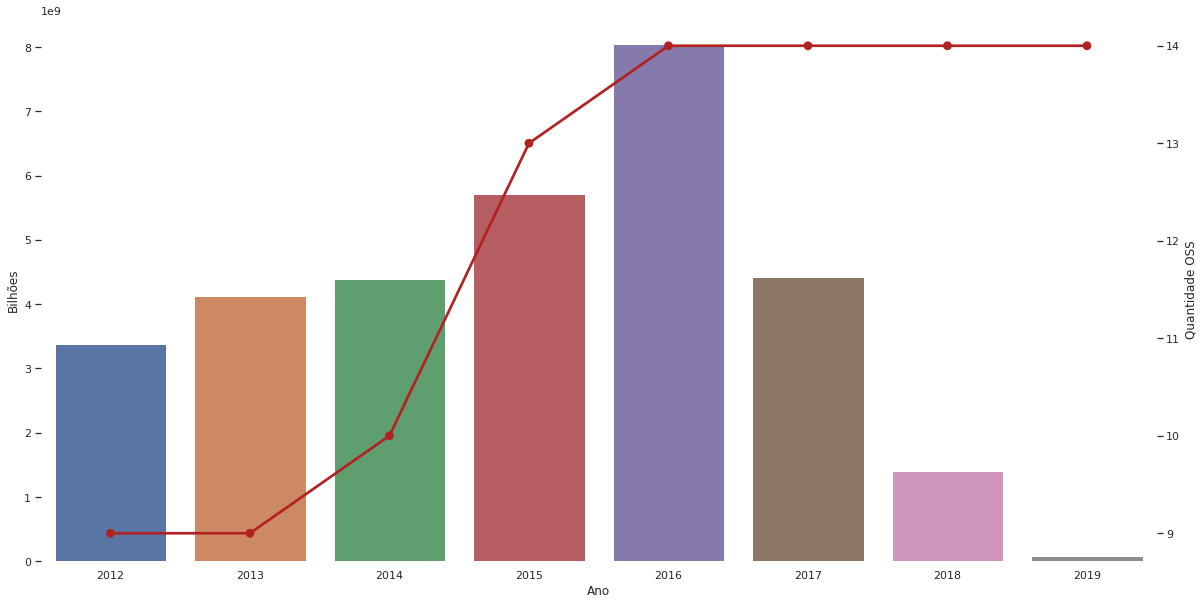

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
sns.barplot(x="ref_ano", y="valor", data=df_gastos_anuais,
            order=range(2012, 2020), ax=ax1)
sns.pointplot(x="ref_ano", y="os_id", data=df_gastos_anuais, color="#B22222",
              order=range(2012, 2020), ax=ax2)
ax1.set(ylabel="Bilhões", xlabel="Ano")
ax2.set(ylabel="Quantidade OSS")
sns.despine(left=True, bottom=True)

#### Gastos anuais declarados por OS

In [18]:
agregacoes = {
    'valor': 'sum'
}
df_gastos_anuais_por_os = dff.groupby(['ref_ano', 'os_nome']).agg(agregacoes)
df_gastos_anuais_por_os.reset_index(inplace=True)

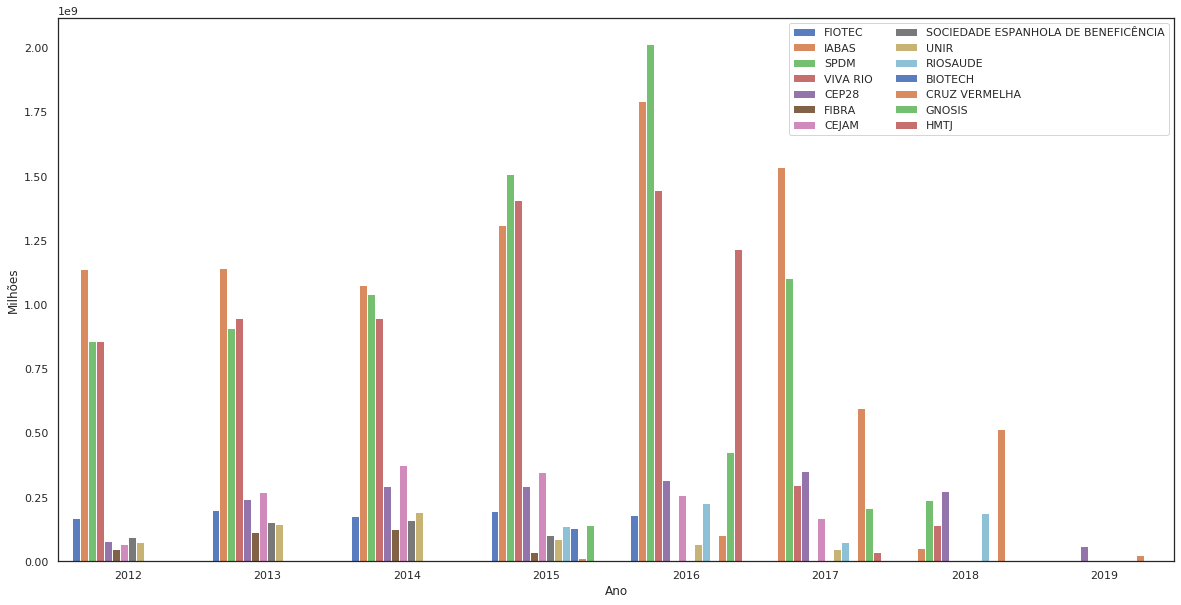

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.catplot(x="ref_ano", y="valor", hue="os_nome", data=df_gastos_anuais_por_os,
            kind="bar", order=range(2012, 2020), palette="muted", ax=ax1)
ax1.legend(ncol=2, loc="upper right", frameon=True)
ax1.set(ylabel="Milhões", xlabel="Ano")
sns.despine(left=True, bottom=True)
plt.close(2)

#### Gastos anuais por Prefeito

In [20]:
agregacoes = {
    'valor': 'sum'
}
df_gastos_anuais_por_prefeito = dff.groupby(['ref_ano', 'prefeito']).agg(agregacoes)
df_gastos_anuais_por_prefeito.reset_index(inplace=True)

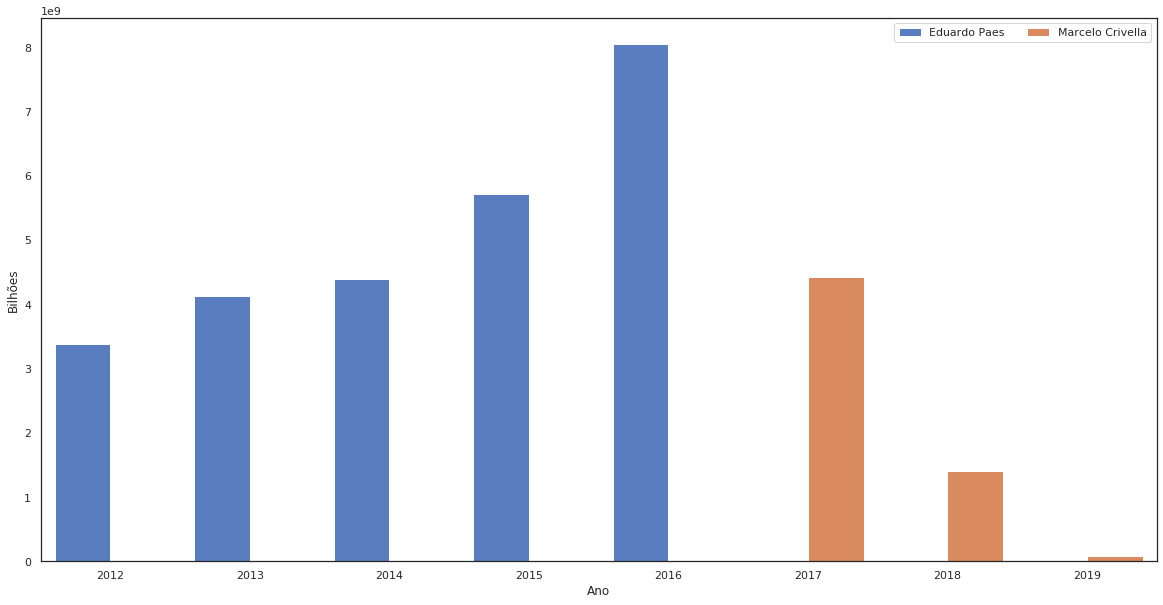

In [21]:
fig, ax1 = plt.subplots(figsize=(20, 10))
df_gastos_anuais_por_prefeito = df_gastos_anuais_por_prefeito[
    (df_gastos_anuais_por_prefeito["ref_ano"] > 2011) &
    (df_gastos_anuais_por_prefeito["ref_ano"] < 2020)
]
sns.catplot(x="ref_ano", y="valor", hue="prefeito", data=df_gastos_anuais_por_prefeito,
            kind="bar", palette="muted", ax=ax1)
ax1.legend(ncol=2, loc="upper right", frameon=True)
ax1.set(ylabel="Bilhões", xlabel="Ano")
sns.despine(left=True, bottom=True)
plt.close(2)

#### Gastos Segmentados por tipo de despesas

In [22]:
agregacoes = {
    'valor': 'sum'
}
df_gastos_os_por_despesa = dff[dff['nivel'] == '1'].groupby(['os_nome', 'despesa']).agg(agregacoes)
df_gastos_os_por_despesa.reset_index(inplace=True)

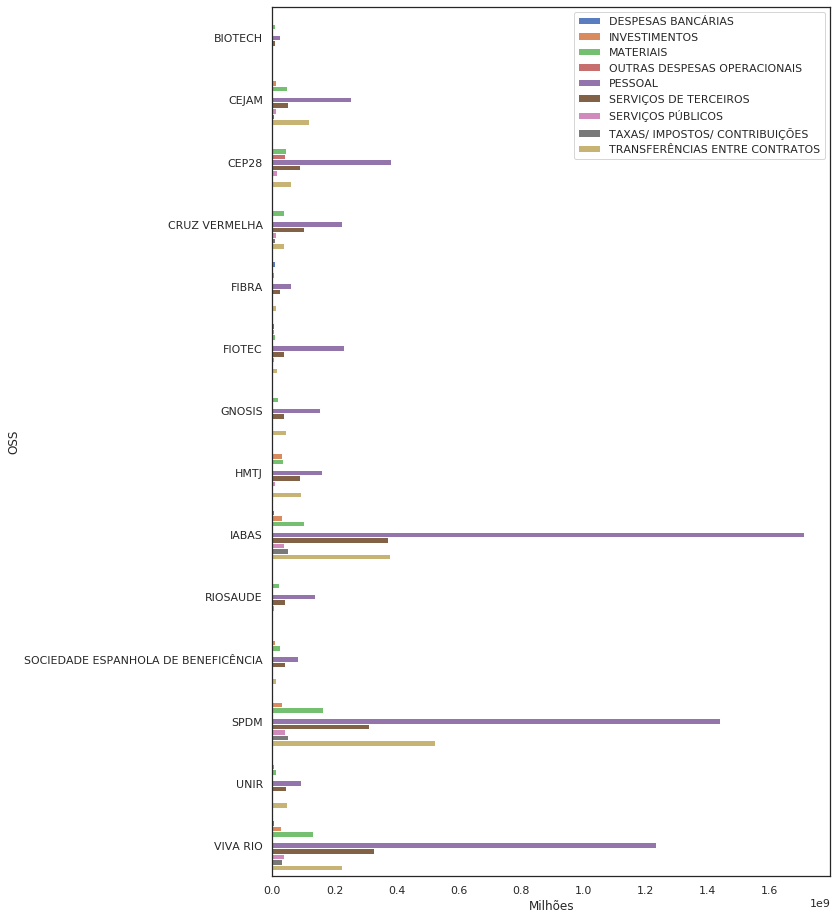

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 16))
sns.catplot(x="valor", y="os_nome", hue="despesa", data=df_gastos_os_por_despesa,
            kind="bar", palette="muted", ax=ax1)
ax1.legend(ncol=1, loc="upper right", frameon=True)
ax1.set(ylabel="OSS", xlabel="Milhões")
sns.despine(left=True, bottom=True)
plt.close(2)

#### Quantidade de contratos por OS

In [24]:
agregacoes = {
    'contrato_id': pd.Series.nunique,
    'valor': 'sum'
}
df_qtd_contrato_por_os = dff.groupby(['ref_ano', 'os_nome']).agg(agregacoes)
df_qtd_contrato_por_os.reset_index(inplace=True)

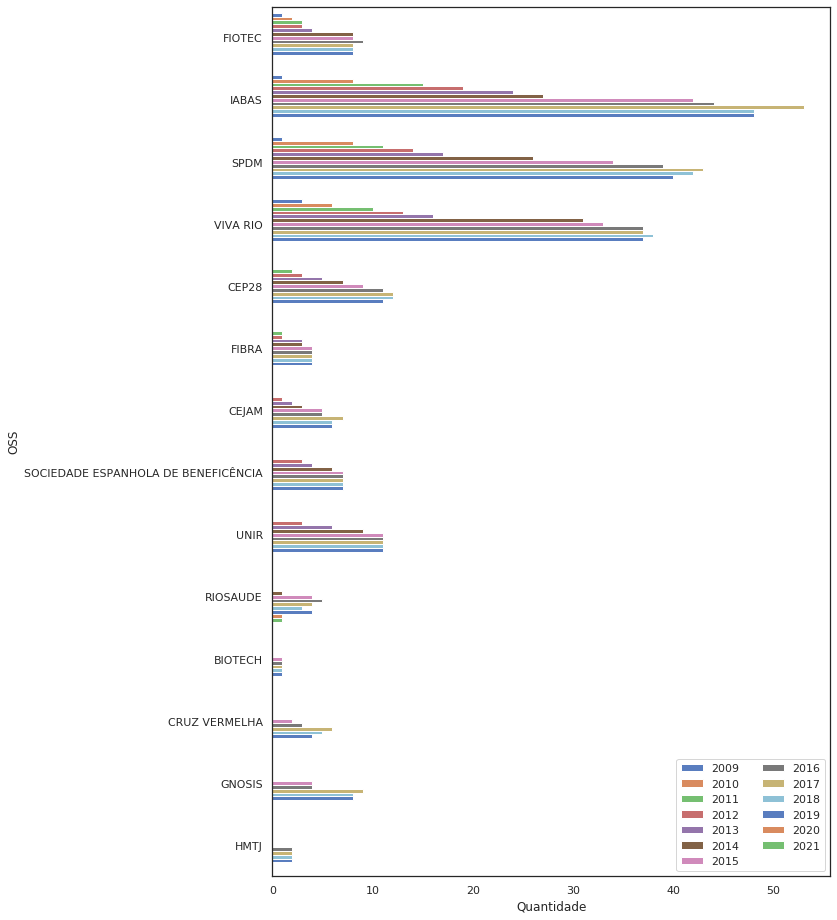

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 16))
sns.catplot(x="contrato_id", y="os_nome", hue="ref_ano", data=df_qtd_contrato_por_os,
            kind="bar", palette="muted", ax=ax1)
ax1.legend(ncol=2, loc="lower right", frameon=True)
ax1.set(ylabel="OSS", xlabel="Quantidade")
sns.despine(left=True, bottom=True)
plt.close(2)